# Import Dependencies

In [6]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [7]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Influencer Category Classification



1.   Read Data
2.   Preprocess Data
3.   Prepare Model
4.   Predict Test Data
4.   Save outputs



In [8]:
train_classification_df = pd.read_csv("/content/train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [ ]:
# stats about the labels
train_classification_df.groupby("category").count()

In [10]:
train_data_path = "/content/training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [ ]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df

In [ ]:
test_profile_df.head(2)

Here our corpus is all of our post data
so we should concat aggregate all of them and provide as a corpus to the Tf-IDF vectorizer of the scikit-learn.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000)

# fit the vectorizer
vectorizer.fit(corpus)


# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [14]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_names

In [ ]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

In [17]:
df_tfidf.shape

(2741, 5000)

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

In [19]:
x_train.shape

(2192, 5000)

In [20]:
x_val.shape

(549, 5000)

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Perform the chi-squared test to identify the most relevant features for each class
chi2_selector = SelectKBest(chi2, k=1000)  # Keep top 1000 words based on Chi-Square score
x_train_chi2 = chi2_selector.fit_transform(x_train, y_train)

# Get the names of the selected features (words)
selected_feature_names = [vectorizer.get_feature_names_out()[i] for i in chi2_selector.get_support(indices=True)]

print(f"Top 1000 words based on Chi-Square: {selected_feature_names}")


Top 1000 words based on Chi-Square: ['adam', 'adidas', 'adresinden', 'adventure', 'aegean', 'afiyet', 'ai', 'aile', 'ajans', 'ak', 'aksesuar', 'akyaka', 'akıllı', 'akşam', 'alanya', 'alarm', 'allah', 'alsancak', 'alışveriş', 'amazingplaces', 'amaçlıdır', 'ambalaj', 'ameliyat', 'analiz', 'anatolium', 'and', 'anne', 'annebebek', 'annem', 'antalya', 'antalyaturkey', 'antep', 'antrenman', 'aquapark', 'araç', 'architecture', 'arda', 'arge', 'arkadaşım', 'art', 'artist', 'asistanı', 'aslan', 'at', 'ateşte', 'atölyesi', 'atıştırmalık', 'available', 'avantajlı', 'avmde', 'avrupa', 'awaits', 'ayakkabı', 'ayar', 'ayran', 'ağrı', 'ağız', 'baba', 'babası', 'baby', 'badem', 'baklava', 'balık', 'bana', 'bar', 'barbie', 'bardağı', 'basketbol', 'baskı', 'bağırsak', 'bağış', 'bağışıklık', 'başarılar', 'başkan', 'başkanı', 'başkanımız', 'başlıyoruz', 'başvurunuz', 'beach', 'beautifuldestinations', 'bebek', 'bebekler', 'bebeklerin', 'bebeğin', 'bebeğinizin', 'beer', 'belediye', 'belediyemiz', 'belediyesi

In [ ]:
#@title Test Data


# let's take a look at the first 5 lines of the file
test_data_path = "/content/test-classification-round3.dat"
!head -n 5 "$test_data_path"

print("*****")

test_unames = []
with open(test_data_path, "rt") as fh:
  for line in fh:
    test_unames.append(line.strip())

print(test_unames[:5])


In [27]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Logistic Regression Model with L1 regularization for Multiclass
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    multi_class='ovr'  # Explicitly define one-vs-rest
)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a range of C values to tune the regularization
param_grid = {'C': np.logspace(-4, 4, 20)}  # Fine-tune over 20 points

# GridSearchCV to tune C
grid_search = GridSearchCV(logreg, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get best C value
best_C = grid_search.best_params_['C']
print(f"Best C value: {best_C}")

# Train model with best C
modelLogReg = LogisticRegression(
    penalty='l1',
    C=best_C,
    solver='liblinear',
    max_iter=1000,
    multi_class='ovr'
)
modelLogReg.fit(x_train, y_train)

# Count non-zero coefficients across all classes
non_zero_coefficients = np.any(modelLogReg.coef_ != 0, axis=0)
selected_feature_count = np.sum(non_zero_coefficients)
print(f"Number of selected features: {selected_feature_count}")

# Adjust C based on feature count
if selected_feature_count < 2000:
    print("Selected features are less than 2000, try increasing the C value.")
elif selected_feature_count > 2000:
    print("Selected features are more than 2000, try decreasing the C value.")
else:
    print("Approximately 2000 features are selected.")

# Filter x_train and x_val based on selected features
selected_features_logistic = x_train.columns[non_zero_coefficients]
x_train_selected = x_train[selected_features_logistic]
x_val_selected = x_val[selected_features_logistic]

# Re-train the model with selected features
modelLogReg.fit(x_train_selected, y_train)

# Evaluate the model
train_accuracy = accuracy_score(y_train, modelLogReg.predict(x_train_selected))
cv_accuracy = cross_val_score(modelLogReg, x_train_selected, y_train, cv=5, scoring='accuracy').mean()

print(f"Train Accuracy: {train_accuracy}")
print(f"Cross-validation Accuracy: {cv_accuracy}")

# Predictions on the validation set
y_pred = modelLogReg.predict(x_val_selected)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Print selected features
print("Selected Features:")
print(selected_features_logistic)

# Print selected features
print("Selected Features:")
print(selected_features_logistic)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best C value: 10000.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Number of selected features: 3963
Selected features are more than 2000, try decreasing the C value.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Train Accuracy: 0.9972627737226277
Cross-validation Accuracy: 0.6090263259171425
Validation Accuracy: 0.6138433515482696
Classification Report:
                      precision    recall  f1-score   support

                 art       0.34      0.37      0.35        38
       entertainment       0.41      0.43      0.42        65
             fashion       0.72      0.52      0.60        60
                food       0.87      0.88      0.87       102
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.56      0.66      0.61       100
    mom and children       0.47      0.30      0.37        30
              sports       0.55      0.52      0.53        23
                tech       0.65      0.75      0.70        69
              travel       0.65      0.59      0.62        59

            accuracy                           0.61       549
           macro avg       0.52      0.50      0.51       549
        weighted avg       0.61      0.61      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


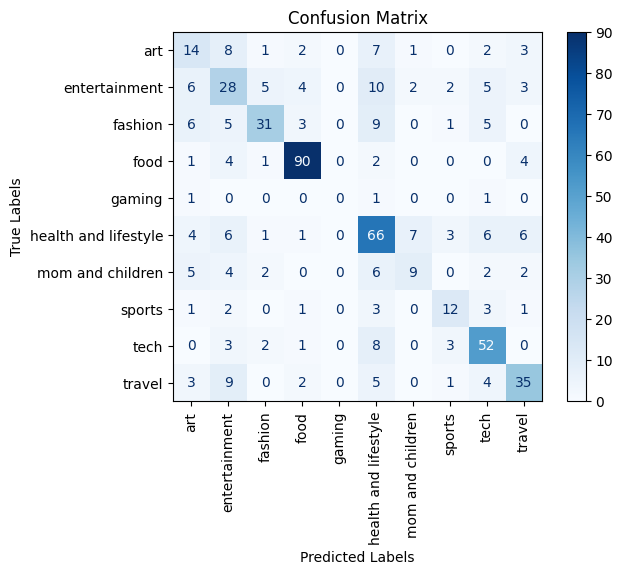

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=modelLogReg.classes_)
disp.plot(cmap='Blues')

# Rotate x-axis labels
plt.xticks(rotation=90)  # Rotate the x-axis labels 90 degrees
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.head(2)

In [ ]:
# Ensure test data contains only the selected features
df_test_selected = df_test[selected_features_logistic]
df_test_selected.head(2)

In [41]:
#test_pred = best_rf_model.predict(df_test)
test_pred = modelLogReg.predict(df_test_selected)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = test_pred[index]

In [42]:
print(f"Total number of features used to train modelLogReg: {x_train_selected.shape[1]}")

Total number of features used to train modelLogReg: 3963


In [43]:
test_pred = modelLogReg.predict(df_test_selected)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = test_pred[index]

In [44]:
with open("output_logisticregression.json", "w") as of:
  json.dump(output, of, indent=4)